# Introduction to rio-tiler + STAC

The goal of this notebook is to give a quick introduction of the rio-tiler STACReader.

# Requirements

To be able to run this notebook you'll need the following requirements:
- rio-tiler~= 5.0
- matplotlib

In [1]:
# !pip install rio-tiler matplotlib

In [2]:
from rio_tiler.io import STACReader
from rio_tiler.profiles import img_profiles
from rio_tiler.models import ImageData

from matplotlib.pyplot import subplots, imshow

## Data

For this demo we will use a STAC Item for the Sentinel-2 data stored as COGs on AWS.

### Sentinel 2 COGs
Thanks to Digital Earth Africa and in collaboration with Sinergise, Element 84, Amazon Web Services (AWS) and the Committee on Earth Observation Satellites (CEOS), Sentinel 2 (Level 2) data over Africa, usually stored as JPEG2000, has been translated to COG more important a STAC database and API has been setup.

https://www.digitalearthafrica.org/news/operational-and-ready-use-satellite-data-now-available-across-africa

In [3]:
# For this DEMO we will use this file
src_path = "https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2A_34SGA_20200318_0_L2A"

## rio_tiler.io.STACReader

In `rio-tiler` 2.0 we introduced STACReader, which is a python class providing usefull methods get and parse the STAC item and then read and inspect any GDAL/rasterio raster assets.

Docs: [https://cogeotiff.github.io/rio-tiler/readers/#stacreader](https://cogeotiff.github.io/rio-tiler/readers/#stacreader) 

In [4]:
?STACReader

#### Initialize the Reader

In [6]:
with STACReader(src_path) as stac:
    pass

# see the list of available assets
print(stac.assets)

# print the bounds
print(stac.bounds)
print(stac.crs)


['overview', 'B11', 'B01', 'B12', 'B02', 'B03', 'B04', 'AOT', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'WVP', 'visual', 'SCL']
[23.293255090449595, 31.505183020453355, 24.296453548295318, 32.51147809805106]
EPSG:4326


### Info

Get some info about some assets

In [7]:
with STACReader(src_path) as stac:
    # This method will return a Dict of `{asset: rio_tiler.models.Info, asset2: rio_tiler.models.Info}`
    # Checkout the docs https://cogeotiff.github.io/rio-tiler/models/#info for more info about the model.
    info = stac.info(assets=("B01", "B02"))
    print("B01:")
    print(info["B01"].model_dump(exclude_none=True))
    print("B02:")
    print(info["B02"].model_dump(exclude_none=True))

B01:
{'bounds': BoundingBox(left=23.106076243528157, bottom=31.505173744374172, right=24.296464503939948, top=32.519334871696195), 'minzoom': 8, 'maxzoom': 11, 'band_metadata': [('b1', {})], 'band_descriptions': [('b1', '')], 'dtype': 'uint16', 'nodata_type': 'Nodata', 'colorinterp': ['gray'], 'height': 1830, 'width': 1830, 'overviews': [2, 4, 8], 'driver': 'GTiff', 'count': 1, 'nodata_value': 0.0}
B02:
{'bounds': BoundingBox(left=23.106076243528157, bottom=31.505173744374172, right=24.296464503939948, top=32.519334871696195), 'minzoom': 8, 'maxzoom': 14, 'band_metadata': [('b1', {})], 'band_descriptions': [('b1', '')], 'dtype': 'uint16', 'nodata_type': 'Nodata', 'colorinterp': ['gray'], 'height': 10980, 'width': 10980, 'overviews': [2, 4, 8, 16], 'driver': 'GTiff', 'count': 1, 'nodata_value': 0.0}


### Statistics

Return basic data statistics

In [8]:
with STACReader(src_path) as stac:
    meta = stac.statistics(assets=("B01", "B02", "B03", "B04"), max_size=256) # Here we use max_size option to limit the data transfer (default to 1024)
    print("available assets statistics:")
    print(list(meta))
    print()
    print("statistics for asset B01:")
    # For each asset, we will get a Dict in form of {"1": BandStatistics(...), ...} with `1` being the band index.
    print(meta["B01"])

available assets statistics:
['B01', 'B02', 'B03', 'B04']

statistics for asset B01:
{'b1': BandStatistics(min=266.0, max=8177.0, mean=2000.2489664959585, count=48621.0, sum=97254105.0, std=1219.279372960457, median=1865.0, majority=322.0, minority=266.0, unique=5132.0, histogram=[[13396.0, 10624.0, 11190.0, 7230.0, 3801.0, 1425.0, 621.0, 244.0, 77.0, 13.0], [266.0, 1057.1, 1848.2, 2639.3, 3430.4, 4221.5, 5012.6, 5803.7, 6594.8, 7385.900000000001, 8177.0]], valid_percent=74.19, masked_pixels=16915.0, valid_pixels=48621.0, percentile_98=4990.0, percentile_2=325.0)}


#### Plot Histogram values

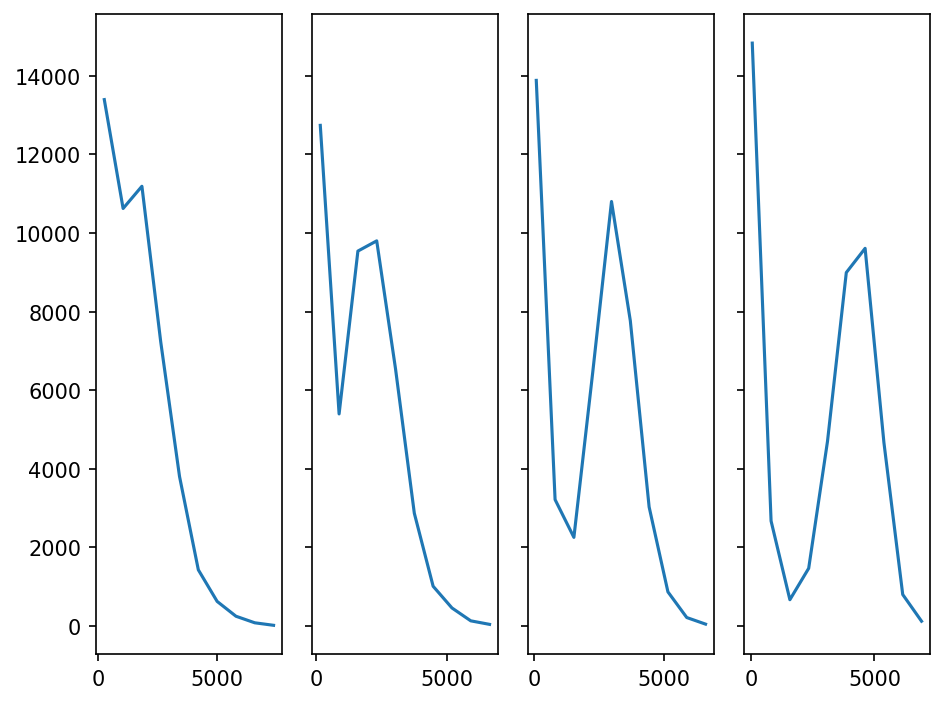

In [9]:
fig, axs = subplots(1, 4, sharey=True, tight_layout=True, dpi=150)

axs[0].plot(meta["B01"]["b1"].histogram[1][0:-1], meta["B01"]["b1"].histogram[0])
axs[1].plot(meta["B02"]["b1"].histogram[1][0:-1], meta["B02"]["b1"].histogram[0])
axs[2].plot(meta["B03"]["b1"].histogram[1][0:-1], meta["B03"]["b1"].histogram[0])
axs[3].plot(meta["B04"]["b1"].histogram[1][0:-1], meta["B04"]["b1"].histogram[0])

### Preview

Read a low resolution version of the data (useful when working with COG, because this method will only fetch the overview layer it needs)

In [10]:
with STACReader(src_path) as stac:
    # By default `preview()` will return an array with its longest dimension lower or equal to 1024px
    img = stac.preview(assets=("B04", "B03", "B02"), max_size=256)
    print(img.data.shape)
    # learn more about the ImageData model https://cogeotiff.github.io/rio-tiler/models/#imagedata
    assert isinstance(img, ImageData)

(3, 256, 256)


#### Display the data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'rio_tiler.models.ImageData'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)


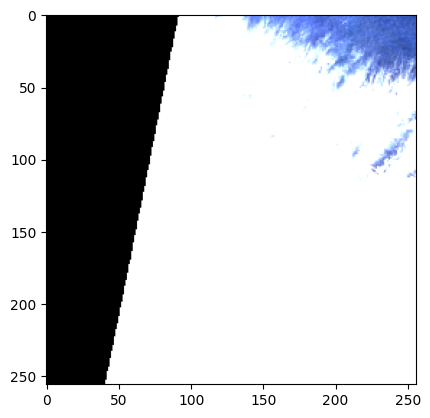

In [11]:
# Rasterio doesn't use the same axis order than visualization libraries (e.g matplotlib, PIL)
# in order to display the data we need to change the order (using rasterio.plot.array_to_image).
# the ImageData class wraps the rasterio function in the `data_as_image()` method.
print(type(img))
print(img.data.shape)

image = img.data_as_image()
# data_as_image() returns a numpy.ndarray in form of (col, row, band)
print(type(image))
print(image.shape)

imshow(image)

0 7671
0 195


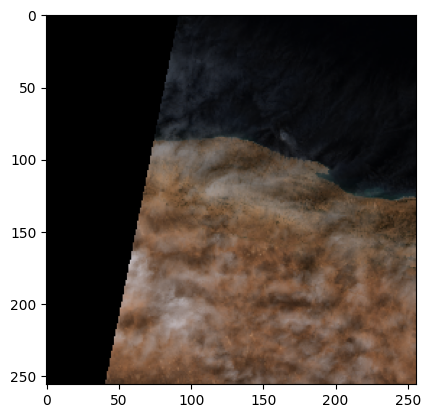

In [12]:
# The sentinel data is stored as UInt16, we need to do some data rescaling to display data from 0 to 255
print(img.data.min(), img.data.max())

img.rescale(in_range=((0, 10000),))
print(img.data.min(), img.data.max())

image = img.data_as_image()
imshow(image)

### Use Expression

(1, 256, 256)
-0.10652920962199312 0.6103714085494043


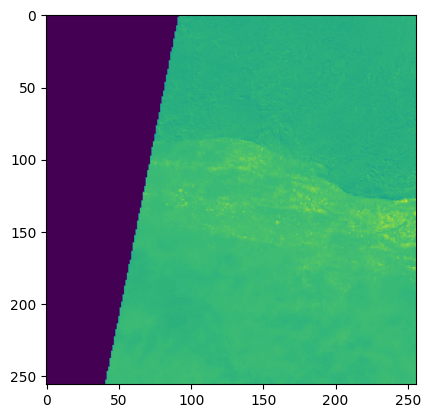

In [13]:
with STACReader(src_path) as stac:
    # By default `preview()` will return an array with its longest dimension lower or equal to 1024px
    img = stac.preview(expression="(B08_b1-B04_b1)/(B08_b1+B04_b1)", max_size=256)
    print(img.data.shape)
    # learn more about the ImageData model https://cogeotiff.github.io/rio-tiler/models/#imagedata
    assert isinstance(img, ImageData)

# NDVI data range should be between -1 and 1
print(img.data.min(), img.data.max())

img.rescale(in_range=((-1,1),))
image = img.data_as_image()
imshow(image)